<a href="https://www.kaggle.com/code/neupane9sujal/binary-classification-lgbm?scriptVersionId=159448263" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedKFold
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.mixture import GaussianMixture
from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
data = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv',low_memory=False)
data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [22]:
original = pd.read_csv('/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv')
original.rename(columns = {'RowNumber':'id'}, inplace = True)
original.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


In [23]:
data = pd.concat([data, original], ignore_index=True)
data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [24]:
test_df = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv',low_memory=False)
test_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


## Exploratory Data Analysis

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175036 entries, 0 to 175035
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               175036 non-null  int64  
 1   CustomerId       175036 non-null  int64  
 2   Surname          175036 non-null  object 
 3   CreditScore      175036 non-null  int64  
 4   Geography        175035 non-null  object 
 5   Gender           175036 non-null  object 
 6   Age              175035 non-null  float64
 7   Tenure           175036 non-null  int64  
 8   Balance          175036 non-null  float64
 9   NumOfProducts    175036 non-null  int64  
 10  HasCrCard        175035 non-null  float64
 11  IsActiveMember   175035 non-null  float64
 12  EstimatedSalary  175036 non-null  float64
 13  Exited           175036 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 18.7+ MB


In [26]:
data.CustomerId.duplicated().value_counts()

CustomerId
True     151615
False     23421
Name: count, dtype: int64

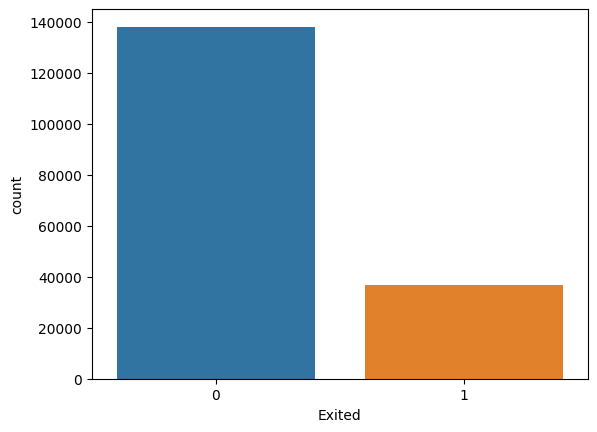

In [27]:
sns.countplot(data=data,x='Exited')
plt.show()

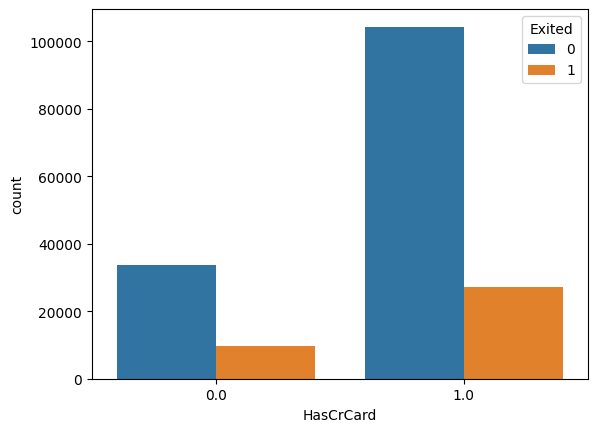

In [28]:
##those who exited having credit card
sns.countplot(data=data,hue='Exited',x='HasCrCard')
plt.show()

In [29]:
def  get_gmm_class_features(feat,n):
    gmm=GaussianMixture(n_components=n,random_state=42)
    gmm.fit(data[feat].fillna(data[feat].median()).values.reshape(-1,1))
    data[f'{feat}_class']=gmm.predict(data[feat].fillna(data[feat].median()).values.reshape(-1,1))
    test_df[f'{feat}_class']=gmm.predict(test_df[feat].fillna(test_df[feat].median()).values.reshape(-1,1))
    
    
get_gmm_class_features('Balance',5)
get_gmm_class_features('EstimatedSalary',5)
get_gmm_class_features('IsActiveMember',2)
get_gmm_class_features('Tenure',5)

In [30]:
def age_tr(df) : 
    df['Age_Category'] = pd.cut(df['Age'], bins=[18, 30, 40, 50, 60, 100], labels=['18-30', '30-40', '40-50', '50-60', '60+'])
    return df
def cred_score_tr(df) : 
    df['Credit_Score_Range'] = pd.cut(df['CreditScore'], bins=[0, 300, 600, 700, 800, 900], labels=['0-300', '300-600', '600-700', '700-800', '900+'])
    return df

def geo_gender_tr(df) : 
    df['Geo_Gender'] = df['Geography'] + '_' + df['Gender']
    return df

data = age_tr(data)
data = cred_score_tr(data)
data = geo_gender_tr(data)

In [60]:
numerical_columns = [col for col in data.columns if data[col].dtype in ['int64','float64'] and col not in ['id','CustomerId','Exited']]
categorical_columns = [col for col in data.columns if data[col].dtype=='object' and col!='Surname']

numerical_preprocessor = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='mean')),
    ('scaler',RobustScaler())
])

categorical_preprocessor = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ("numerical",numerical_preprocessor,numerical_columns),
    ("categorical",categorical_preprocessor,categorical_columns)
])

In [63]:
def apply_vectorizer(train, test):
    vectorizer = TfidfVectorizer(max_features=1000)
    train_surname_tfidf = vectorizer.fit_transform(train['Surname'])
    test_surname_tfidf = vectorizer.transform(test['Surname'])
    train = train.drop(columns=['Surname'])
    test = test.drop(columns=['Surname'])
    train = pd.concat([train, pd.DataFrame(train_surname_tfidf.toarray(), columns=vectorizer.get_feature_names_out())], axis=1)
    test = pd.concat([test, pd.DataFrame(test_surname_tfidf.toarray(), columns=vectorizer.get_feature_names_out())], axis=1)
    return train, test

data, test_df = apply_vectorizer(data, test_df)

In [64]:
lgb_params = {'metric': 'auc', 'max_depth': 10, 'min_child_samples': 3, 'learning_rate': 0.03386298381536438, 'n_estimators': 783, 'min_child_weight': 3, 'subsample': 0.3126307540618602, 'colsample_bytree': 0.5197052087982339, 'reg_alpha': 0.4520433059597312, 'reg_lambda': 0.3567348635215261, 'seed': 42} 

In [71]:
target_col = ['Exited']

train_cols = numerical_columns + categorical_columns

model_dict = {}
scores = {'auc_roc':[], 'brier':[]}

test_df = age_tr(test_df)
test_df = cred_score_tr(test_df)
test_df = geo_gender_tr(test_df)

test_predict_list = []
for i in range(5):
    rkf = RepeatedKFold(n_splits=17, n_repeats=1, random_state=42+i)
    oof_valid_probs = np.zeros(data[train_cols].shape[0])

    for fold, (train_idx, valid_idx) in enumerate(rkf.split(data[train_cols])):
        X_train, y_train = data.iloc[train_idx][train_cols], np.array(data.iloc[train_idx][target_col]).ravel()
        X_valid, y_valid = data.iloc[valid_idx][train_cols], np.array(data.iloc[valid_idx][target_col]).ravel()

        X_train = preprocessor.fit_transform(X_train)
        X_valid = preprocessor.transform(X_valid)

        model = LGBMClassifier(**lgb_params)
        early_stopping_callback = lgb.early_stopping(75,first_metric_only=True,verbose=False)
        verbose_callback = lgb.log_evaluation(500)
        model.fit(X_train, y_train, eval_set=[(X_valid,y_valid)],
                 callbacks=[early_stopping_callback,verbose_callback])
        valid_probs = model.predict_proba(X_valid)[:,1]
        oof_valid_probs[valid_idx] = valid_probs

        test = preprocessor.transform(test_df)

        test_probs = model.predict_proba(test)[:,1]
        test_predict_list.append(test_probs)

        auc_score = roc_auc_score(y_valid, valid_probs)
        brier_score = brier_score_loss(y_valid, valid_probs)
        model_dict[f'{fold}_{i}'] = model

    oof_auc_score = roc_auc_score(data[target_col], oof_valid_probs)
    oof_brier_score = brier_score_loss(data[target_col], oof_valid_probs)
    scores['auc_roc'].append(oof_auc_score)
    scores['brier'].append(oof_brier_score)

0it [00:00, ?it/s]

[500]	valid_0's auc: 0.886162


1it [00:21, 21.28s/it]

[500]	valid_0's auc: 0.890893


2it [00:40, 20.31s/it]

[500]	valid_0's auc: 0.887921


4it [01:09, 16.23s/it]

[500]	valid_0's auc: 0.895416


5it [01:29, 17.58s/it]

[500]	valid_0's auc: 0.891138


6it [01:47, 17.70s/it]

[500]	valid_0's auc: 0.894266


7it [02:04, 17.64s/it]

[500]	valid_0's auc: 0.888699


8it [02:20, 16.89s/it]

[500]	valid_0's auc: 0.886032


11it [02:59, 13.98s/it]

[500]	valid_0's auc: 0.887171


12it [03:14, 14.16s/it]

[500]	valid_0's auc: 0.892788


16it [04:03, 12.28s/it]

[500]	valid_0's auc: 0.887054


17it [04:19, 15.28s/it]


Iteration:  0
auc-score:  [0.8893617975919763]


0it [00:00, ?it/s]

[500]	valid_0's auc: 0.88757


1it [00:19, 19.62s/it]

[500]	valid_0's auc: 0.89537


2it [00:38, 19.23s/it]

[500]	valid_0's auc: 0.889078


3it [00:55, 17.96s/it]

[500]	valid_0's auc: 0.888779


4it [01:13, 18.11s/it]

[500]	valid_0's auc: 0.888937


6it [01:44, 16.23s/it]

[500]	valid_0's auc: 0.88727


7it [02:03, 17.41s/it]

[500]	valid_0's auc: 0.884392


8it [02:23, 18.12s/it]

[500]	valid_0's auc: 0.890158


9it [02:38, 17.08s/it]

[500]	valid_0's auc: 0.890733


11it [03:03, 14.21s/it]

[500]	valid_0's auc: 0.892739


12it [03:21, 15.48s/it]

[500]	valid_0's auc: 0.887131


14it [03:49, 14.84s/it]

[500]	valid_0's auc: 0.880656


15it [04:04, 14.87s/it]

[500]	valid_0's auc: 0.889974


16it [04:20, 15.11s/it]

[500]	valid_0's auc: 0.891583


17it [04:37, 16.35s/it]


Iteration:  1
auc-score:  [0.8893617975919763, 0.8893949462835793]


0it [00:00, ?it/s]

[500]	valid_0's auc: 0.883278


1it [00:20, 20.73s/it]

[500]	valid_0's auc: 0.885669


2it [00:35, 17.42s/it]

[500]	valid_0's auc: 0.884613


4it [01:04, 15.15s/it]

[500]	valid_0's auc: 0.888194


5it [01:20, 15.58s/it]

[500]	valid_0's auc: 0.894764


6it [01:35, 15.16s/it]

[500]	valid_0's auc: 0.895539


7it [01:52, 15.88s/it]

[500]	valid_0's auc: 0.892809


8it [02:10, 16.67s/it]

[500]	valid_0's auc: 0.890377


10it [02:33, 13.66s/it]

[500]	valid_0's auc: 0.890508


13it [03:09, 12.48s/it]

[500]	valid_0's auc: 0.888602


14it [03:24, 13.23s/it]

[500]	valid_0's auc: 0.884514


16it [03:48, 12.24s/it]

[500]	valid_0's auc: 0.889204


17it [04:07, 14.57s/it]


Iteration:  2
auc-score:  [0.8893617975919763, 0.8893949462835793, 0.8892383404472693]


0it [00:00, ?it/s]

[500]	valid_0's auc: 0.887162


1it [00:21, 21.17s/it]

[500]	valid_0's auc: 0.881521


2it [00:35, 17.12s/it]

[500]	valid_0's auc: 0.890435


4it [01:05, 15.56s/it]

[500]	valid_0's auc: 0.886892


6it [01:33, 13.91s/it]

[500]	valid_0's auc: 0.893543


7it [01:48, 14.45s/it]

[500]	valid_0's auc: 0.894701


8it [02:08, 16.23s/it]

[500]	valid_0's auc: 0.895022


9it [02:26, 16.62s/it]

[500]	valid_0's auc: 0.891929


10it [02:42, 16.40s/it]

[500]	valid_0's auc: 0.880299


11it [02:58, 16.29s/it]

[500]	valid_0's auc: 0.887823


13it [03:24, 14.60s/it]

[500]	valid_0's auc: 0.889783


15it [03:56, 14.89s/it]

[500]	valid_0's auc: 0.893682


17it [04:23, 15.52s/it]


Iteration:  3
auc-score:  [0.8893617975919763, 0.8893949462835793, 0.8892383404472693, 0.8892021394478776]


0it [00:00, ?it/s]

[500]	valid_0's auc: 0.888107


1it [00:15, 15.35s/it]

[500]	valid_0's auc: 0.889787


2it [00:35, 18.17s/it]

[500]	valid_0's auc: 0.886598


3it [00:57, 19.70s/it]

[500]	valid_0's auc: 0.893872


4it [01:16, 19.75s/it]

[500]	valid_0's auc: 0.889649


5it [01:30, 17.68s/it]

[500]	valid_0's auc: 0.893767


6it [01:46, 16.98s/it]

[500]	valid_0's auc: 0.891652


7it [02:06, 17.83s/it]

[500]	valid_0's auc: 0.887453


8it [02:26, 18.62s/it]

[500]	valid_0's auc: 0.885576


10it [02:57, 16.67s/it]

[500]	valid_0's auc: 0.889364


11it [03:14, 16.79s/it]

[500]	valid_0's auc: 0.888025


12it [03:33, 17.24s/it]

[500]	valid_0's auc: 0.889473


13it [03:49, 16.99s/it]

[500]	valid_0's auc: 0.888882


14it [04:03, 16.14s/it]

[500]	valid_0's auc: 0.887117


16it [04:32, 15.09s/it]

[500]	valid_0's auc: 0.894126


17it [04:52, 17.20s/it]

Iteration:  4
auc-score:  [0.8893617975919763, 0.8893949462835793, 0.8892383404472693, 0.8892021394478776, 0.8894758059369361]


In [72]:
np.mean(scores['auc_roc'])

0.8893346059415277

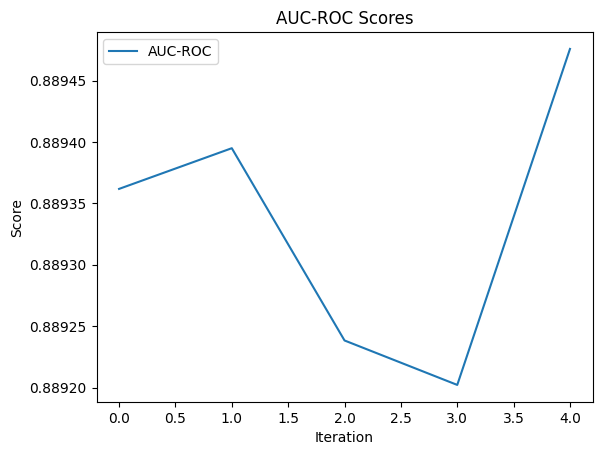

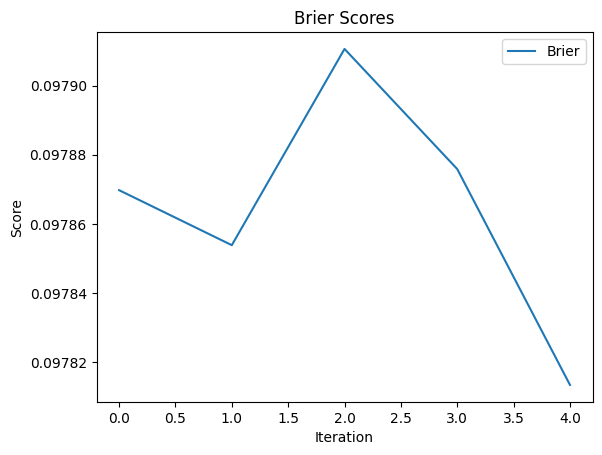

In [73]:
# Palllot AUC-ROC scores
plt.plot(scores['auc_roc'], label='AUC-ROC')
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.title('AUC-ROC Scores')
plt.legend()
plt.show()

# Plot Brier scores
plt.plot(scores['brier'], label='Brier')
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.title('Brier Scores')
plt.legend()
plt.show()

In [74]:
preds = np.mean(test_predict_list,axis=0)
submit = pd.DataFrame({'id':test_df['id'],
                      'Exited':preds})
submit.to_csv('submission.csv',index=False)
submit

,id,Exited
0,165034,0.028637
1,165035,0.822895
2,165036,0.026809
3,165037,0.232499
4,165038,0.347930
...,...,...
110018,275052,0.035929
110019,275053,0.135544
110020,275054,0.019344
110021,275055,0.147522
